# Code Imports

In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, matthews_corrcoef
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from keras_tuner import Objective
from tensorflow import keras
import tensorflow as tf
import xgboost as xgb

2024-08-29 21:57:04.573826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 21:57:04.573981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 21:57:04.735625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Problem Definition
## 1.1 Scenario

Welcome back! Today, our client has given us the task of binary classification of mushrooms. The client lives far out in a magical forest and needs an application to help her identify which mushrooms she can eat and which she cannot. Luckily for us, she brought with her an ancient tome of mushroom classification. The book is pretty old, though, and some of the text is messed up- so we will have to work around that. She is hoping that we can come up with a model, so she does not have to flip through every page of this massive book. Oh, and she's hoping that your model will not get her sick either! 

## 1.2 Scoring Metric
For our client, we will be using the Matthews correlation coefficient (MCC). What does this mean? The MCC is a scoring equation that is calculated using true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). For you nerds, here is the full equation. 

$$
\text{MCC} = \frac{(TP \times TN) - (FP \times FN)}{\sqrt{(TP + FP) \times (TP + FN) \times (TN + FP) \times (TN + FN)}}
$$

The MCC is great for binary classification, especially where datasets are imbalanced in favor of one type of classification. The other thing to know is that this equation will give us a score from -1 to 1, where -1 is total misclassification, 0 is no predictive power (randomly guessing), and 1 is a perfect classification. 

# 2. Data Collection and Analysis
## 2.1 Import Data and Look at Raw Reads
Alright, let's look at this data that our client has collect from her massive tome.  

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [3]:
pd.set_option('display.max_columns', None)
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


## 2.2 Visualizations
The biggest problem we are going to have with this dataset is the number of artifacts that can be found in each column. 

From the table below, we see that there are quite a few unique values per column. In addition, it does not seem that the data dictionary found [here](https://archive.ics.uci.edu/dataset/73/mushroom) or [here](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset) correlates exactly with our dataset. While it seems very close, both data dictionaries do not seem to describe all variables in our dataset. Lets see what percentage each value makes in each column with the code below. 

If we are trying to reduce these values per column, a good cutoff looks like any row value that is < .1% of the total count values in a column. We will handle that in our data cleaning section. 

**NOTE** The numerical column **cap-diameter** has 4 null values. If you miss this, you're going to have some head scratching errors with training later. 

In [5]:
unique_counts = {}

for column in train_df.columns:
    unique_counts[column] = train_df[column].nunique()

unique_counts_series = pd.Series(unique_counts)

print(unique_counts_series)

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-root                    38
stem-surface                 60
stem-color                   59
veil-type                    22
veil-color                   24
has-ring                     23
ring-type                    40
spore-print-color            32
habitat                      52
season                        4
dtype: int64


In [6]:
def calculate_category_percentages(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"Column: {column}")
            percentage = df[column].value_counts(normalize=True) * 100
            print(f"{percentage.to_string()}\n")

calculate_category_percentages(train_df)

Column: class
class
p    54.713702
e    45.286298

Column: cap-shape
cap-shape
x            46.072177
f            21.695817
s            11.715019
b            10.223154
o             3.491765
p             3.431834
c             3.353326
d             0.002085
e             0.001925
n             0.001315
t             0.001155
w             0.001155
g             0.001091
y             0.001059
r             0.001027
a             0.000962
u             0.000866
z             0.000706
l             0.000674
i             0.000449
k             0.000417
h             0.000192
m             0.000064
8             0.000064
3.55          0.000064
7 x           0.000064
4.97          0.000064
3.25          0.000032
11.12         0.000032
3 x           0.000032
4.3           0.000032
7.41          0.000032
6.21          0.000032
8.29          0.000032
7.21          0.000032
54.78         0.000032
2.82          0.000032
20.25         0.000032
3.52          0.000032
3.04          0.000032
6

veil-type               2957493
spore-print-color       2849682
stem-root               2757023
veil-color              2740947
stem-surface            1980861
gill-spacing            1258435
cap-surface              671023
gill-attachment          523936
ring-type                128880
gill-color                   57
habitat                      45
cap-shape                    40
stem-color                   38
has-ring                     24
cap-color                    12
does-bruise-or-bleed          8
cap-diameter                  4
id                            0
stem-width                    0
class                         0
stem-height                   0
season                        0
dtype: int64


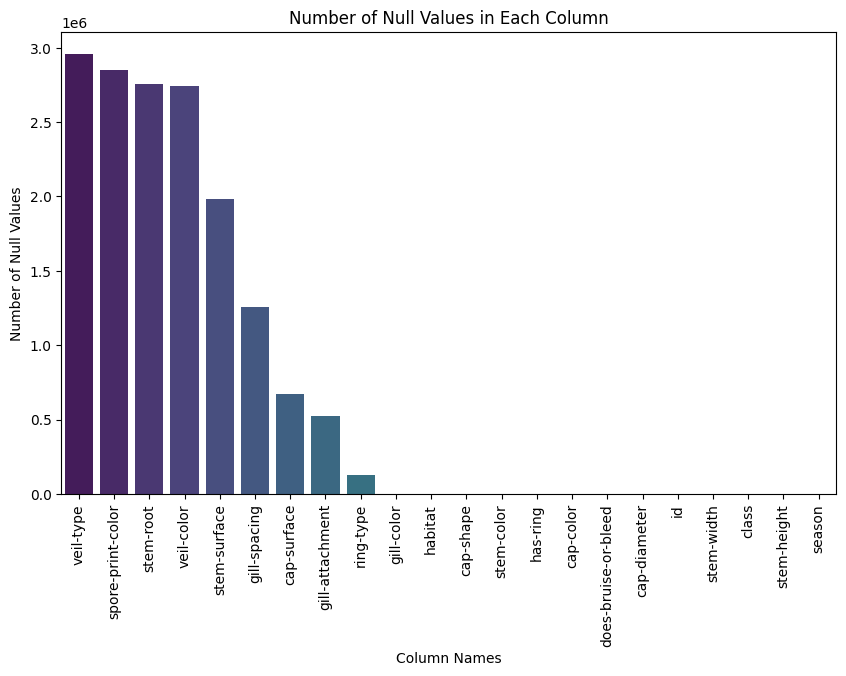

In [7]:
null_counts = train_df.isnull().sum()
null_counts = null_counts.sort_values(ascending=False)

print(null_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts.index, y=null_counts.values, palette='viridis')

plt.title('Number of Null Values in Each Column')
plt.xlabel('Column Names')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=90)

plt.show()

In [8]:
duplicate_count = train_df.duplicated().sum()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


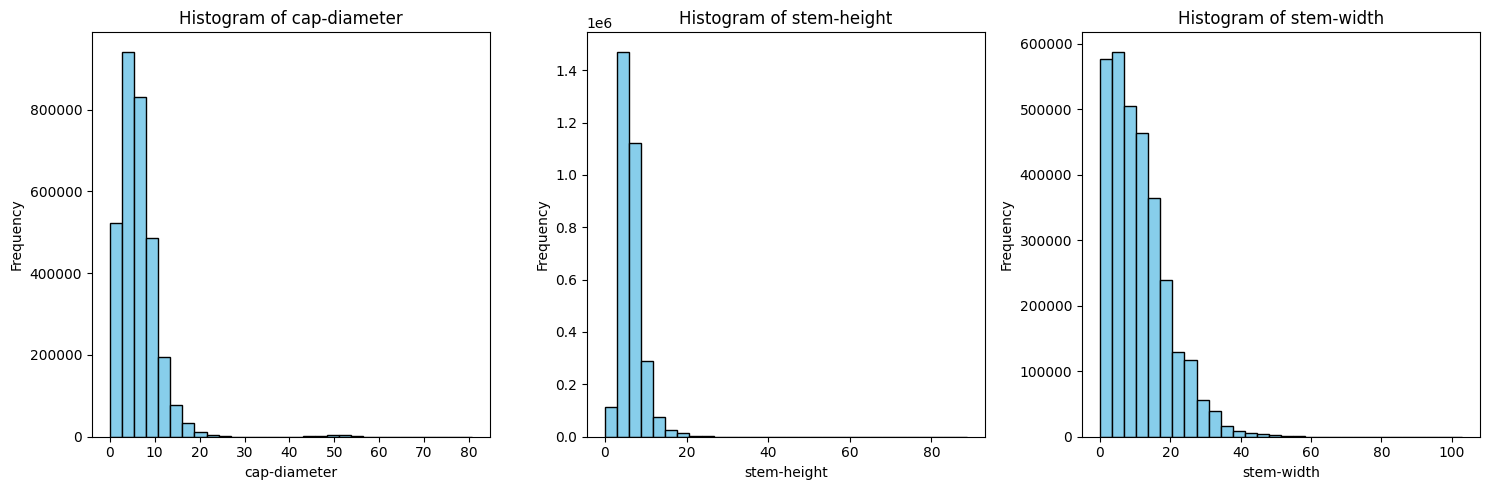

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(train_df.select_dtypes(include=['float64']).columns):
    axes[i].hist(train_df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

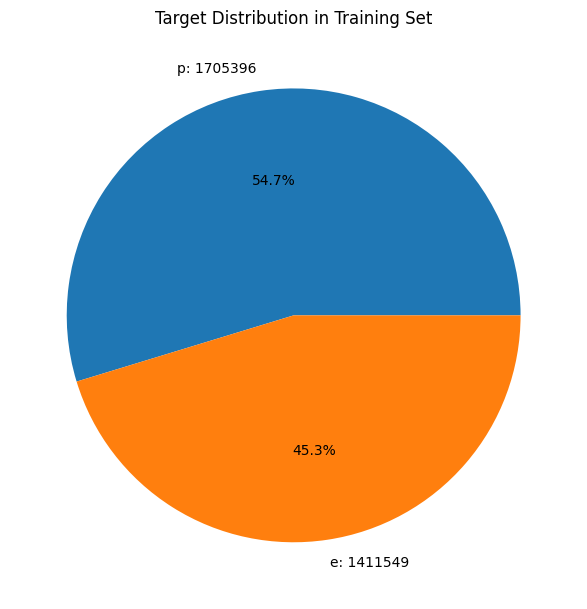

In [10]:
y = train_df['class']

train_target_distribution = y.value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(train_target_distribution, 
        labels=[f'{label}: {count}' for label, count in train_target_distribution.items()], 
        autopct='%1.1f%%', 
        colors=['#1f77b4', '#ff7f0e']) 
plt.title('Target Distribution in Training Set')

plt.tight_layout()
plt.show()


## 2.3 First Thoughts
* We have a **ton** of training data. Good news for us, we will be able to split this into a train, dev, test set. 
* There are a lot of data artifacts in the set. In the next section, we will define .1% as the cutoff for artifacts that will get reassigned to another value. 
* Null values will also have to be handled. 
* No duplicates, that's a good sign. 

# 3. Data Cleaning
## 3.1 Replacing Null and Artifacts
Now that we have a good sense of what data we are working with, let's get it ready for a model. First, let's handle those data artifacts by writing a function to rewrite those smaller values and any null values we might have. Intuitively, we know already that we are probably going to be using a Deep Neural Network (DNN) for this problem. 

One important note about this method, if our production data set had a different distribution of values, we would need to edit this code slightly so that our train, validation, and test dataframe columns lined up with our production dataframe. This is especially important for something like a densely connected deep neural net. 

In [11]:
for col in train_df.select_dtypes(include=['float64']).columns:
    train_df[col] = train_df[col].fillna(0)

In [12]:
def rewrite_values(df, threshold=0.1):
    for column in df.columns:
        if df[column].dtype == 'object':
            total_count = df[column].notna().sum()
            value_counts = df[column].value_counts()
            replace_dict = {value: 'not' if count / total_count < (threshold / 100) else value for value, count in value_counts.items()}
            df[column] = df[column].map(replace_dict).fillna('null')

rewrite_values(train_df)

In [13]:
unique_counts = {}

for column in train_df.columns:
    unique_counts[column] = train_df[column].nunique()

unique_counts_series = pd.Series(unique_counts)

print(unique_counts_series)

id                      3116945
class                         2
cap-diameter               3914
cap-shape                     9
cap-surface                  13
cap-color                    14
does-bruise-or-bleed          4
gill-attachment               9
gill-spacing                  5
gill-color                   14
stem-height                2749
stem-width                 5836
stem-root                     7
stem-surface                  9
stem-color                   14
veil-type                     3
veil-color                    8
has-ring                      4
ring-type                    10
spore-print-color             9
habitat                      10
season                        4
dtype: int64


## 3.2 Prepare Data for Model
Alright, we handled our null values and data artifacts. Below, we are going to one hot encode our categorical values. I won't explain one hot encoding, but you can find a summary [here](https://www.geeksforgeeks.org/ml-one-hot-encoding/). We are also going to normalize our continuous variables between 0 and 1 for the NN. High level: we normalize our continuous variables to help with training our NN.

In [14]:
scaler = MinMaxScaler()

df_encoded = pd.get_dummies(train_df, columns=train_df.select_dtypes(include=['object']).columns, dtype=int)
continuous_cols = df_encoded.select_dtypes(include=['float64']).columns
df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])

df_encoded = df_encoded.drop(['id'], axis=1)

pd.set_option('display.max_columns', None)
df_encoded.head()

,cap-diameter,stem-height,stem-width,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_not,cap-shape_null,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,cap-surface_d,cap-surface_e,cap-surface_g,cap-surface_h,cap-surface_i,cap-surface_k,cap-surface_l,cap-surface_not,cap-surface_null,cap-surface_s,cap-surface_t,cap-surface_w,cap-surface_y,cap-color_b,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_not,cap-color_null,cap-color_o,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,does-bruise-or-bleed_f,does-bruise-or-bleed_not,does-bruise-or-bleed_null,does-bruise-or-bleed_t,gill-attachment_a,gill-attachment_d,gill-attachment_e,gill-attachment_f,gill-attachment_not,gill-attachment_null,gill-attachment_p,gill-attachment_s,gill-attachment_x,gill-spacing_c,gill-spacing_d,gill-spacing_f,gill-spacing_not,gill-spacing_null,gill-color_b,gill-color_e,gill-color_f,gill-color_g,gill-color_k,gill-color_n,gill-color_not,gill-color_null,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stem-root_b,stem-root_c,stem-root_f,stem-root_not,stem-root_null,stem-root_r,stem-root_s,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_not,stem-surface_null,stem-surface_s,stem-surface_t,stem-surface_y,stem-color_b,stem-color_e,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_not,stem-color_null,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y,veil-type_not,veil-type_null,veil-type_u,veil-color_e,veil-color_k,veil-color_n,veil-color_not,veil-color_null,veil-color_u,veil-color_w,veil-color_y,has-ring_f,has-ring_not,has-ring_null,has-ring_t,ring-type_e,ring-type_f,ring-type_g,ring-type_l,ring-type_m,ring-type_not,ring-type_null,ring-type_p,ring-type_r,ring-type_z,spore-print-color_g,spore-print-color_k,spore-print-color_n,spore-print-color_not,spore-print-color_null,spore-print-color_p,spore-print-color_r,spore-print-color_u,spore-print-color_w,habitat_d,habitat_g,habitat_h,habitat_l,habitat_m,habitat_not,habitat_null,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,0.109086,0.050834,0.149563,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.055907,0.053990,0.062974,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.086030,0.077209,0.096501,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0.048097,0.046889,0.063460,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.072518,0.037985,0.081244,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


## 3.3 Creating our Train and Dev Sets
Since our data set is so large, we will be able to train a very accurate deep neural network. Additionally, we will be able to have three data sets- train, dev, and test sets. We will want our largest dataset to be the training set (duh) while we can keep our other two datasets relatively small <50k rows. Below, we do a 99.98%/.01%/.01% data split (very small!). 

In [15]:
df_encoded_x = df_encoded.drop(columns=['class_e', 'class_p'])
df_encoded_y = df_encoded['class_e']

In [16]:
train_data_x, temp_data_x, train_data_y, temp_data_y = train_test_split(df_encoded_x, df_encoded_y, test_size=0.02, random_state=16)
dev_data_x, test_data_x, dev_data_y, test_data_y = train_test_split(temp_data_x, temp_data_y, test_size=.5, random_state=16)

print(f"Train set size: {len(train_data_x)} rows")
print(f"Dev set size: {len(dev_data_x)} rows")
print(f"Test set size: {len(test_data_x)} rows")

Train set size: 3054606 rows
Dev set size: 31169 rows
Test set size: 31170 rows


# 4 Initial Model Testing
## 4.1 Define a Custom MCC Metric Function
Remember that scoring metric we mentioned earlier? Tensorflow has depreciated that [metric](https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MatthewsCorrelationCoefficient), so we will have to define our own.

In [17]:
def mcc(y_true, y_pred):
    y_pred_pos = tf.round(tf.clip_by_value(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_true_pos = tf.round(tf.clip_by_value(y_true, 0, 1))
    y_true_neg = 1 - y_true_pos

    y_pred_pos = tf.cast(y_pred_pos, tf.float32)
    y_pred_neg = tf.cast(y_pred_neg, tf.float32)
    y_true_pos = tf.cast(y_true_pos, tf.float32)
    y_true_neg = tf.cast(y_true_neg, tf.float32)

    tp = tf.reduce_sum(y_true_pos * y_pred_pos)
    tn = tf.reduce_sum(y_true_neg * y_pred_neg)
    fp = tf.reduce_sum(y_true_neg * y_pred_pos)
    fn = tf.reduce_sum(y_true_pos * y_pred_neg)

    numerator = (tp * tn) - (fp * fn)
    denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    mcc = tf.where(tf.math.equal(denominator, 0), 0.0, numerator / denominator)
    return mcc

## 4.2 Define a DNN
Below we will define a very simple DNN, with two hidden layers, with the specific parameters listed in the code. We are going to use binary cross entropy as our loss function, but in future iterations, we will consider using our custom MCC function as the loss function. 

Beware, using a custom loss function can introduce unforeseen complexity and issues in an optimization problem. Training our model using binary cross entropy and our custom loss function will give us a good idea of comparison between the two.

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_data_x.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[mcc])

In [19]:
DNN = model.fit(train_data_x, train_data_y, epochs=5, batch_size=512, validation_data = (dev_data_x, dev_data_y))


Epoch 1/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0784 - mcc: 0.9499 - val_loss: 0.0392 - val_mcc: 0.9831
Epoch 2/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0417 - mcc: 0.9814 - val_loss: 0.0393 - val_mcc: 0.9829
Epoch 3/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0406 - mcc: 0.9821 - val_loss: 0.0372 - val_mcc: 0.9834
Epoch 4/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0401 - mcc: 0.9825 - val_loss: 0.0375 - val_mcc: 0.9835
Epoch 5/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0394 - mcc: 0.9828 - val_loss: 0.0370 - val_mcc: 0.9839


Already we see our model performing very well in just 5 epcohs. 
# 5 Initial Model Validation
## 5.1 Loss

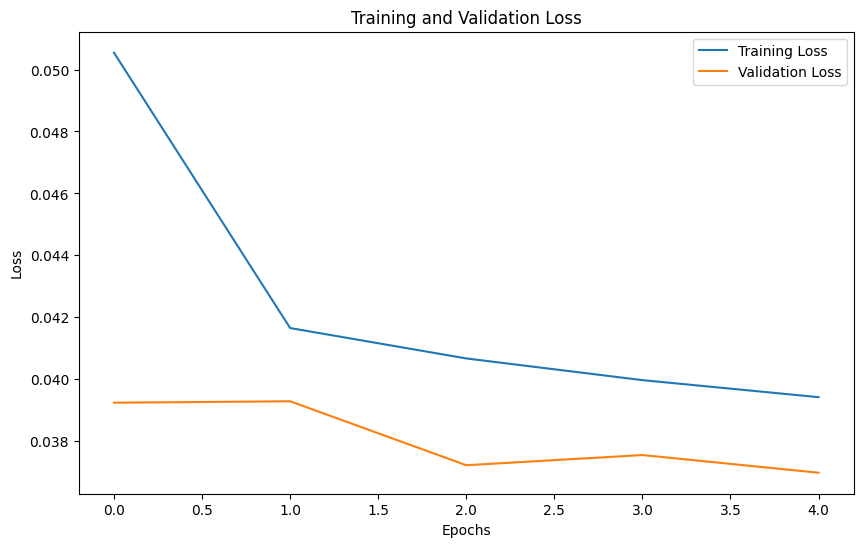

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(DNN.history['loss'], label='Training Loss')
plt.plot(DNN.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.2 MCC Metric

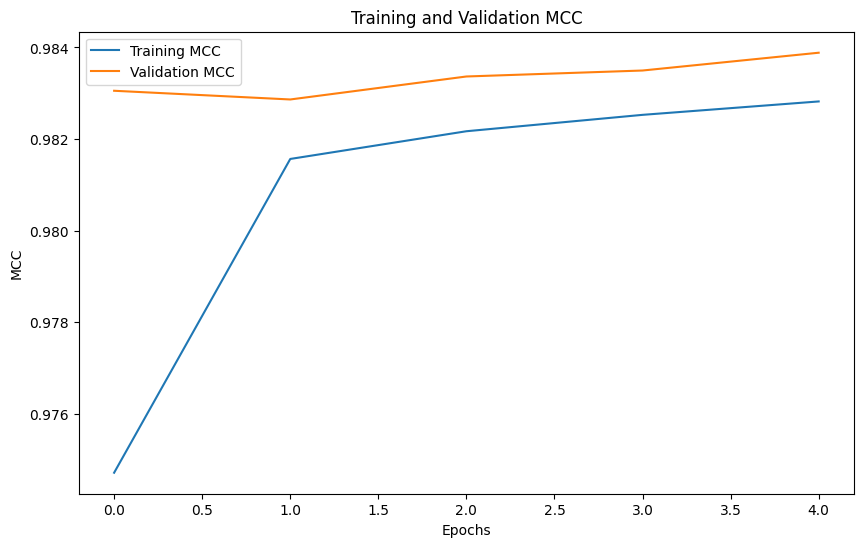

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(DNN.history['mcc'], label='Training MCC')
plt.plot(DNN.history['val_mcc'], label='Validation MCC')
plt.title('Training and Validation MCC')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.legend()
plt.show()

In [22]:
print(f"Difference between training and validation MCC metric:\n{abs(DNN.history['mcc'][-1] - DNN.history['val_mcc'][-1])}")

Difference between training and validation MCC metric:
0.0010633468627929688


Our test data MCC metric is very low, which means our model fits very well to this set (low bias). The final difference between our training MCC metric and our validation MCC metric is also very small, which means our model is able to generalize efficently (low variance)!  
## 5.3 Test Data Set - Final Model Evaluation

In [23]:
test_loss, test_metrics = model.evaluate(test_data_x, test_data_y)

print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

975/975 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0382 - mcc: 0.9838
Test Loss: 0.04161429405212402
Test Metrics: 0.9811778664588928


In [24]:
print(f"Difference between training and test MCC metric:\n{abs(DNN.history['mcc'][-1] - test_metrics)}")
print(f"\nDifference between validation and test MCC metric:\n{abs(DNN.history['val_mcc'][-1] - test_metrics)}")

Difference between training and test MCC metric:
0.001643836498260498

Difference between validation and test MCC metric:
0.002707183361053467


What we are looking for here is our training, validation, and test metric. 

If the difference going from training -> test data is high, that means we might have overfitted our model to the training and validation data (high variance). 

If the difference going from validation -> test data is high, that means we might have just overfitted on the validation data. This could also mean that our validation data and our test data do not come from the same distribution, which is also a problem we should check. 

Since both differences in MCC metrics are low, this means our model is generalizing well to the test data set, and our test data set is probably from the same distribution of data as our validation data set. 
# 6 Model Deployment
## 6.1 Data Aggregation Pipeline
It is time to deploy our model and see how it works in a production environment! First we will need to define a data pipeline to apply all our data aggregation methods in a streamlined fashion. We will reuse the code we wrote above for this process.

In [25]:
run = False

In [26]:
def remove_num_na(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].fillna(0)
    return df

def rewrite_values(df, threshold=0.1):
    for column in df.columns:
        if df[column].dtype == 'object':
            total_count = df[column].notna().sum()
            value_counts = df[column].value_counts()
            replace_dict = {
                value: 'not' if count / total_count < (threshold / 100) else value for value, count in value_counts.items()}
            df[column] = df[column].map(replace_dict).fillna('null')
    return df

def normalize(df): 
    scaler = MinMaxScaler()
    continuous_cols = df.select_dtypes(include=['float64']).columns
    df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    return df

def encode(df): 
    df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, dtype=int)
    return df
    
def data_pipeline(df):
    df = remove_num_na(df)
    df = rewrite_values(df)
    df = normalize(df)
    df = encode(df)
    return df

def data_pipeline2(df):
    df = remove_num_na(df)
    df = rewrite_values(df)
    return df

In [27]:
if run: 
    test_ids = test_df['id']
    test_features = test_df.drop(columns=['id'])

    df_prod = data_pipeline(test_features)
    predictions = model.predict(df_prod)

    predicted_classes = (predictions > 0.5).astype(int)
    submission_df = pd.DataFrame({
        'id': test_ids,
        'class' : pd.Series(predicted_classes.flatten()).map({1: "e", 0: "p"})
    })

    submission_df.head()

# 7 It's a Race Gary!!
So of course, the final thing to consider is that, yes, we are competing against 1k+ lovely other data scientist. So, what do we do? 

Hyperparameter tuning and ensemble! 

After working with some of these models, I found that the XGBoost was the easiest to train and hypertune. The Linear SVC I could not get to converge, though with more time and tuning, I believe a solution could be achieved. 
## 7.1 Hyperparameter Tuning the DNN
Since this is the meat and bones of squeezing the last bit of percentage points of your model, I will give you some generalized code to get you started. 

The below code will let you control parameters such as number of layers, units per layer (in sets of 32 nodes), dropout rate, and learning rate. You can also control the number of trials (how many different combinations we will search), number of executions (how many times each combination of parameters gets to try and be the best), epochs, and minibatch size.

In [28]:
class HyperModeler(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.InputLayer(input_shape=(train_data_x.shape[1],)))

        for i in range(hp.Int('num_layers', 2, 10)):
            units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
            model.add(keras.layers.Dense(units=units, activation='relu'))
            
            if hp.Boolean('dropout'):
                dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
                model.add(keras.layers.Dropout(rate=dropout_rate))
        
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model


# tuner = RandomSearch(
#     HyperModeler(),
#     objective="val_accuracy",
#     max_trials=20,
#     executions_per_trial=2,
#     directory='kaggle',
#     project_name='s04e08'
# )


# with tf.device('/GPU:0'):
#     tuner.search(
#         train_data_x, train_data_y,
#         epochs=10,  
#         validation_data=(dev_data_x, dev_data_y),
#         batch_size=128,  
#     )

In [29]:
if run: 
    model_path = '/kaggle/input/your-model-folder/model.h5'

    search1 = tf.keras.models.load_model('/kaggle/input/mushroomsearch/tensorflow2/default/1/search_model_2.h5', compile=False)
    search1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mcc])
    #search1.summary()
    test_loss, test_metrics = search1.evaluate(test_data_x, test_data_y)

    print(f"Test Loss: {test_loss}")
    print(f"Test Metrics: {test_metrics}")

## 7.2 Random Forest Classifier
Below you will find some Random Forest Classifier code to get you started. 

A couple notes about the Random Forest. We do not need to normalize or standardize our continuous data values. In addition, training a RFC on 3 million+ rows of data is quite **computationally expensive**. It is highly recommended to shrink the dataset down to about a million rows. 

In the hyperparameter search code you can see that we included a Principal Component Analysis line. This will reduce the dimensions of our data when they expand from one hot encoding. 

Finally, our RFC can be (and should be) used for feature importance selection. The code below will graph the importance for each feature.

In [30]:
if run:
    train_df = data_pipeline(train_df)
    X = train_df.drop(columns=['class_e', 'class_p'])
    y = train_df['class_e']

    train_x, temp_x, train_y, temp_y = train_test_split(X, y, test_size=0.7, random_state=16)
    drop_x, val_x, drop_y, val_y = train_test_split(temp_x, temp_y, test_size=0.01, random_state=16)


    print("Training...")
    model = RandomForestClassifier(
        n_estimators=50, 
        max_depth=15, 
        min_samples_split=10, 
        min_samples_leaf=5, 
        random_state=16
    )
    model.fit(train_x, train_y)
    y_pred = model.predict(val_x)

    print(classification_report(val_y, y_pred))
    mcc = matthews_corrcoef(val_y, y_pred)
    print(f'Matthews Correlation Coefficient: {mcc:.5f}')

    feature_importances = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importance - Random Forest")
    plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [31]:
if run: 
    categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()
    categorical_columns.remove('class')

    onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
    X_encoded = onehot_encoder.fit_transform(train_df[categorical_columns])
    X_encoded_df = pd.DataFrame(X_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))
    X_non_categorical = train_df.drop(columns=categorical_columns + ['class'])

    X = pd.concat([X_non_categorical.reset_index(drop=True), X_encoded_df], axis=1)

    pca = PCA(n_components=0.95)  
    X_reduced = pca.fit_transform(X)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train_df['class'])

    train_x, temp_x, train_y, temp_y = train_test_split(X_reduced, y, test_size=0.9, random_state=24)
    drop_x, val_x, drop_y, val_y = train_test_split(temp_x, temp_y, test_size=0.02, random_state=24)

    print(train_x.shape)
    print(val_x.shape)

    best_mcc_score = 0  

    def objective(trial):
        global best_mcc_score

        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_float('max_features', 0.1, 1.0)

        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=16,
            n_jobs=-1,
            verbose=1
        )

        mcc_scorer = make_scorer(matthews_corrcoef)
        score = cross_val_score(clf, train_x, train_y, cv=5, scoring=mcc_scorer).mean()

        if score > best_mcc_score:
            best_mcc_score = score
            print(f"New best MCC score: {best_mcc_score:.4f}")

        print(f"Best MCC score after trial {trial.number}: {best_mcc_score:.4f}\n")

        return score

    print("Creating the Optuna study...")
    study = optuna.create_study(direction='maximize') 
    print("Starting the optimization process...")
    study.optimize(objective, n_trials=20)

    print("Optimization finished!")
    print("Best hyperparameters: ", study.best_params)

    print("Training the model with the best hyperparameters...")
    best_clf = RandomForestClassifier(**study.best_params, random_state=16, verbose=1)
    best_clf.fit(train_x, train_y)

    print("Saving the best model...")
    joblib.dump(best_clf, 'best_random_forest_model_optuna.pkl')

    print("Evaluating the best model on the test set...")
    y_pred = best_clf.predict(val_x)
    mcc_test = matthews_corrcoef(val_y, y_pred)
    print(f"MCC on Test Set: {mcc_test:.4f}")


## 7.3 XGBoost
Just like our RFC we do not need to normalize or standardize our data. We call the datapile here because we are lazy. With XGBoost, we do not need to shrink our dataset down. 

XGBoost can also be used for feature selection and is interesting to compare to our RFC. 

Again, some boiler plate XGBoost code is included to get you started. 

In [32]:
if run: 
    train_df = data_pipeline(train_df)
    X = train_df.drop(columns=['class_e', 'class_p'])
    y = train_df['class_e']

    train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.01, random_state=16)

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dval = xgb.DMatrix(val_x, label=val_y)

    def mcc_eval(preds, dtrain):
        labels = dtrain.get_label()
        preds = [1 if p > 0.5 else 0 for p in preds]
        mcc = matthews_corrcoef(labels, preds)
        return 'MCC', mcc

    params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.05,
        'max_depth': 10,
        'eval_metric': 'logloss',
        'verbosity': 2,
        'seed': 16
    }

    evals = [(dtrain, 'train'), (dval, 'eval')]
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals, custom_metric=mcc_eval, verbose_eval=True)

    y_pred = bst.predict(dval)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred]

    mcc_score = matthews_corrcoef(val_y, y_pred)
    print(f'Matthews Correlation Coefficient: {mcc_score:.4f}')

    xgb.plot_importance(bst, importance_type='weight')
    plt.show()

In [33]:
if run: 
    train_df = data_pipeline(train_df)
    X = train_df.drop(columns=['class_e', 'class_p'])
    y = train_df['class_e']

    def mcc_eval(preds, dtrain):
        labels = dtrain.get_label()
        preds = np.round(preds)  
        return 'MCC', matthews_corrcoef(labels, preds)

    def objective(trial):
        param = {
            "objective": "binary:logistic",
            "booster": "gbtree",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "max_depth": trial.suggest_int("max_depth", 1, 15),
            "subsample": trial.suggest_float("subsample", 0.5, 1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "lambda": trial.suggest_float("lambda", 1, 10),
            "alpha": trial.suggest_float("alpha", 0, 10),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
            "random_state": 16,
        }

        trial_number = trial.number
        print(f"\nStarting Trial #{trial_number + 1}")
        print(f"Hyperparameters: {param}")

        start_time = time.time()

        train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.01, random_state=16)

        model = xgb.XGBClassifier(**param, use_label_encoder=False)
        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=100)

        y_pred = model.predict(val_x)
        mcc = matthews_corrcoef(val_y, y_pred)

        print(f"Trial #{trial_number + 1} MCC: {mcc}")

        if not hasattr(objective, "best_mcc") or mcc > objective.best_mcc:
            objective.best_mcc = mcc
            joblib.dump(model, "best_xgboost_model.pkl")  
            print(f"New best model saved with MCC: {mcc}")
        print(f"Best MMC: {objective.best_mcc}")
        end_time = time.time()
        print(f"Trial #{trial_number + 1} completed in {end_time - start_time:.2f} seconds\n")

        return mcc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40)

    print("\nOptimization completed.")
    print(f"Best MCC: {study.best_value}")
    print(f"Best Hyperparameters: {study.best_params}")

## 7.4 Linear SVC (Nonconvergent)
The final classifier we are going to use is a SVC. Again, find the starter code below. 

I will leave this code here for future investigation, but I was unable to get the Linear SVC to converge on a solution for this problem. 

In [34]:
if run: 
    train_df = data_pipeline(train_df)
    X = train_df.drop(columns=['class_e', 'class_p'])
    y = train_df['class_e']

    train_x, temp_x, train_y, temp_y = train_test_split(X, y, test_size=0.7, random_state=16)
    drop_x, val_x, drop_y, val_y = train_test_split(temp_x, temp_y, test_size=0.01, random_state=16)

    model = LinearSVC(random_state=16, verbose=True)
    model.fit(train_x, train_y)

    y_pred = model.predict(val_x)

    print("Accuracy:", accuracy_score(val_y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(val_y, y_pred))
    print("Classification Report:\n", classification_report(val_y, y_pred))

In [35]:
if run: 
    def objective(trial):
        print(f"Starting Trial {trial.number}")
        C = trial.suggest_float('C', 1e-6, 1e+6, log=True)
        loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
        max_iter = trial.suggest_int('max_iter', 1000, 5000)

        model = LinearSVC(C=C, loss=loss, max_iter=max_iter, verbose=True, random_state=16)

        scorer = make_scorer(matthews_corrcoef)
        scores = cross_val_score(model, train_x, train_y, cv=3, scoring=scorer, n_jobs=-1)
        score_mean = scores.mean()

        print(f"Trial {trial.number}: Score = {score_mean:.4f}")

        return score_mean

    train_df = data_pipeline(train_df)
    X = train_df.drop(columns=['class_e', 'class_p'])
    y = train_df['class_e']

    train_x, temp_x, train_y, temp_y = train_test_split(X, y, test_size=0.9, random_state=16)
    drop_x, val_x, drop_y, val_y = train_test_split(temp_x, temp_y, test_size=0.02, random_state=16)
    print(train_x.shape)
    print(val_x.shape)

    def print_trial_results(study, trial):
        print(f"Completed trial {trial.number} with value: {trial.value:.4f}")
        print(f"Best score so far: {study.best_value:.4f}")

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20, callbacks=[print_trial_results])

    print("Best Parameters:", study.best_params_)
    print("Best Cross-Validation MCC Score:", study.best_value)

    best_params = study.best_params_
    best_model = LinearSVC(C=best_params['C'], loss=best_params['loss'], max_iter=best_params['max_iter'], random_state=42)
    best_model.fit(train_x, train_y)

    y_pred = best_model.predict(val_x)
    test_mcc = matthews_corrcoef(val_y, y_pred)
    print("Test Set MCC:", test_mcc)

    joblib.dump(best_model, 'best_linear_svc_model_optuna.pkl')
    print("Best model saved as 'best_linear_svc_model_optuna.pkl'.")

## 7.5 Ensemble with Multiple Models (Coming Soon)
We have reached the final part of our journey! Time to take all our hypertuned models and put them together in an ensembled model. 

Below, we load in several coded dataframes. The frames were compiled outside of the notebook, but the process is still the same as what we did in earlier sections. 

We clear up some memory as well, just for some extra overhead. 

We see the that ensembled model does well on the validation dataset and we also see it generalizes well to our test data set.

In [36]:
del train_data_x
del temp_data_x
del train_data_y
del temp_data_y
del DNN
del model
del scaler
del df_encoded
del df_encoded_x
del df_encoded_y
del unique_counts
del unique_counts_series

gc.collect()

12114

In [37]:
pca = joblib.load('/kaggle/input/pca1/scikitlearn/default/1/pca_model.pkl')

In [38]:
X_dev = pd.read_csv("/kaggle/input/pca-encoded-train-sets/pca_encoded_dev.csv", keep_default_na=False)
X_reduced_dev = pca.transform(X_dev)

X_test = pd.read_csv("/kaggle/input/pca-encoded-train-sets/pca_encoded_test.csv", keep_default_na=False)
X_reduced_test = pca.transform(X_test)

In [39]:
X_prod = pd.read_csv("/kaggle/input/pca-encoded-test/pca_encoded_test.csv", keep_default_na=False)
X_prod = X_prod.drop(columns=['id'])
X_reduced_prod = pca.transform(X_prod)

In [40]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
test_ids = test_df['id']
test_features = test_df.drop(columns=['id'])

df_prod = data_pipeline(test_features)

In [41]:
print("Loading models...")
nn_model = tf.keras.models.load_model('/kaggle/input/mushroomsearch/tensorflow2/default/1/search_model_2.h5', compile=False)
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mcc])
xgb_model = joblib.load('/kaggle/input/xgboost/other/default/1/best_xgboost_model.pkl')
rf_model = joblib.load('/kaggle/input/random-forest/scikitlearn/default/1/best_random_forest_model_optuna.pkl')

Loading models...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:02:33] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [42]:
print("Predicting on the validation set...")
val_preds_rf = rf_model.predict(X_reduced_dev)
val_preds_nn = nn_model.predict(dev_data_x)
val_preds_xgb = xgb_model.predict(dev_data_x)

print("Predicting on the test set...")
test_preds_rf = rf_model.predict(X_reduced_test)
test_preds_nn = nn_model.predict(test_data_x)
test_preds_xgb = xgb_model.predict(test_data_x)

X_val_meta = np.column_stack((val_preds_rf, val_preds_nn, val_preds_xgb))
X_test_meta = np.column_stack((test_preds_rf, test_preds_nn, test_preds_xgb))

meta_model = LogisticRegression()
meta_model.fit(X_val_meta, dev_data_y)

val_meta_preds = meta_model.predict(X_val_meta)
mcc_val = matthews_corrcoef(dev_data_y, val_meta_preds)
print(f'Matthews Correlation Coefficient on Validation Set: {mcc_val:.4f}')

test_meta_preds = meta_model.predict(X_test_meta)
mcc_test = matthews_corrcoef(test_data_y, test_meta_preds)
print(f'Matthews Correlation Coefficient on Test Set: {mcc_test:.4f}')

print("Predicting on the production set...")
prod_preds_rf = rf_model.predict(X_reduced_prod)
prod_preds_nn = nn_model.predict(df_prod)
prod_preds_xgb = xgb_model.predict(df_prod)

X_prod_meta = np.column_stack((prod_preds_rf, prod_preds_nn, prod_preds_xgb))

prod_meta_preds = meta_model.predict(X_prod_meta)
predicted_classes = (prod_meta_preds > 0.5).astype(int)
submission_df = pd.DataFrame({
    'id': test_ids,
    'class' : pd.Series(predicted_classes.flatten()).map({1: "e", 0: "p"})
})

print(submission_df.head())
submission_df.to_csv("submission.csv", index=False)

Predicting on the validation set...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Predicting on the test set...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Matthews Correlation Coefficient on Validation Set: 0.9863
Matthews Correlation Coefficient on Test Set: 0.9846
Predicting on the production set...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.8s


64937/64937 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step
        id class
0  3116945     e
1  3116946     p
2  3116947     p
3  3116948     p
4  3116949     e


# 8 Conclusion
Well, that's it! That's the end. Thanks for making it all the way through. 

If you were looking for extra steps (because why wouldn't you?), there are a few areas we can go back to and improve on. The biggest areas would be- 

1. Continue to find better hyperparameters for our models. 
2. Try different meta models for the ensemble. 
3. Discover different features of the dataset using feature engineering. 

Good luck!